In [2]:
import utils
import plotting
import postprocessing
import corrections
from collections import OrderedDict

from utils import CUT_MAX_VAL, ShapeVar
from hh_vars import (
    years,
    data_key,
    qcd_key,
    bg_keys,
    samples,
    nonres_sig_keys,
    nonres_samples,
    txbb_wps,
    jec_shifts,
    jmsr_shifts,
)
from postprocessing import nonres_shape_vars, Region

import numpy as np
import pandas as pd
import pickle

# from pandas.errors import SettingWithCopyWarning
from hist import Hist

import os
from copy import deepcopy
from inspect import cleandoc
import warnings

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

# ignore these because they don't seem to apply
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
MAIN_DIR = "../../../"
samples_dir = f"{MAIN_DIR}/../data/skimmer/anava/Test"
samples_dir = '/home/users/annava/projects/HHbbVV/src/HHbbVV/VBF_binder/data'
# samples_dir = "/eos/uscms/store/user/anava/bbVV/skimmer/Test/"
year = "2017"

date = "23Sep2"
plot_dir = f"../../../plots/PostProcessing/{date}/"
plot_dir = '/home/users/annava/projects/HHbbVV/src/HHbbVV/VBF_binder/vbf_tests_output'
templates_dir = f"templates/{date}"
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {plot_dir}/cutflows/")
_ = os.system(f"mkdir -p {plot_dir}/ControlPlots/{year}/")
_ = os.system(f"mkdir -p {plot_dir}/templates/")
# _ = os.system(f"mkdir -p {plot_dir}/templates/wshifts")
# _ = os.system(f"mkdir -p {plot_dir}/templates/jshifts")
# _ = os.system(f"mkdir -p {templates_dir}")
print(plot_dir)

/home/users/annava/projects/HHbbVV/src/HHbbVV/VBF_binder/vbf_tests_output


Load samples

In [5]:
filters = postprocessing.new_filters
systematics = {year: {}}

# save cutflow as pandas table
cutflow = pd.DataFrame(index=list(samples.keys()) + list(nonres_samples.keys()))

# utils.remove_empty_parquets(samples_dir, year)
events_dict = utils.load_samples(samples_dir, nonres_samples, year, filters)
events_dict |= utils.load_samples(samples_dir, samples, year, filters)

utils.add_to_cutflow(events_dict, "Preselection", "weight", cutflow)

cutflow

Loaded GluGluToHHTobbVV_node_cHHH1                       : 164044 entries
Loaded GluGluToHHTobbVV_node_cHHH2p45                    : 312540 entries
Loaded GluGluToHHTobbVV_node_cHHH5                       : 45377 entries
Loaded GluGluToHHTobbVV_node_cHHH0                       : 120480 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_1                      : 18095 entries
Loaded VBF_HHTobbVV_CV_1_C2V_0_C3_1                      : 407474 entries
Loaded VBF_HHTobbVV_CV_1_5_C2V_1_C3_1                    : 295890 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_2                      : 20805 entries
Loaded VBF_HHTobbVV_CV_1_C2V_2_C3_1                      : 758367 entries
Loaded VBF_HHTobbVV_CV_1_C2V_1_C3_0                      : 18391 entries
Loaded VBF_HHTobbVV_CV_0_5_C2V_1_C3_1                    : 748656 entries
Loaded QCD_HT1000to1500                                  : 95410 entries
Loaded QCD_HT100to200                                    : 0 entries
Loaded QCD_HT1500to2000                         

,Preselection
QCD,2.193080e+06
TT,1.471054e+05
ST,1.336835e+04
V+Jets,6.317644e+04
Diboson,9.859687e+02
ggFHbb,3.946397e+02
VBFHbb,1.046515e+02
ZHbb,1.044506e+02
WHbb,1.593979e+02
ggZHbb,1.524993e+01


Scale factors and bb VV assignment

In [6]:
postprocessing.apply_weights(events_dict, year, cutflow)
bb_masks = postprocessing.bb_VV_assignment(events_dict)
# events_dict[sig_key] = postprocessing.postprocess_lpsfs(events_dict[sig_key])
cutflow


QCD_SCALE_FACTOR = 0.8706922767186228


,Preselection,TriggerEffs,QCD SF
QCD,2.193080e+06,1.152934e+06,1.003851e+06
TT,1.471054e+05,9.521809e+04,9.521809e+04
ST,1.336835e+04,8.895333e+03,8.895333e+03
V+Jets,6.317644e+04,3.844857e+04,3.844857e+04
Diboson,9.859687e+02,6.242251e+02,6.242251e+02
ggFHbb,3.946397e+02,2.378208e+02,2.378208e+02
VBFHbb,1.046515e+02,6.836515e+01,6.836515e+01
ZHbb,1.044506e+02,6.775973e+01,6.775973e+01
WHbb,1.593979e+02,1.035296e+02,1.035296e+02
ggZHbb,1.524993e+01,1.008643e+01,1.008643e+01


Control plots

[ShapeVar(var='DijetMass', label='$m^{jj}$ (GeV)', bins=[30, 600, 4000], reg=True, blind_window=None, significance_dir='right'), ShapeVar(var='bbFatJetPt', label='$p^{bb}_T$ (GeV)', bins=[30, 300, 1500], reg=True, blind_window=None, significance_dir='right'), ShapeVar(var='bbFatJetParticleNetMass', label='$m^{bb}_{reg}$ (GeV)', bins=[20, 50, 250], reg=True, blind_window=None, significance_dir='bin')]
None


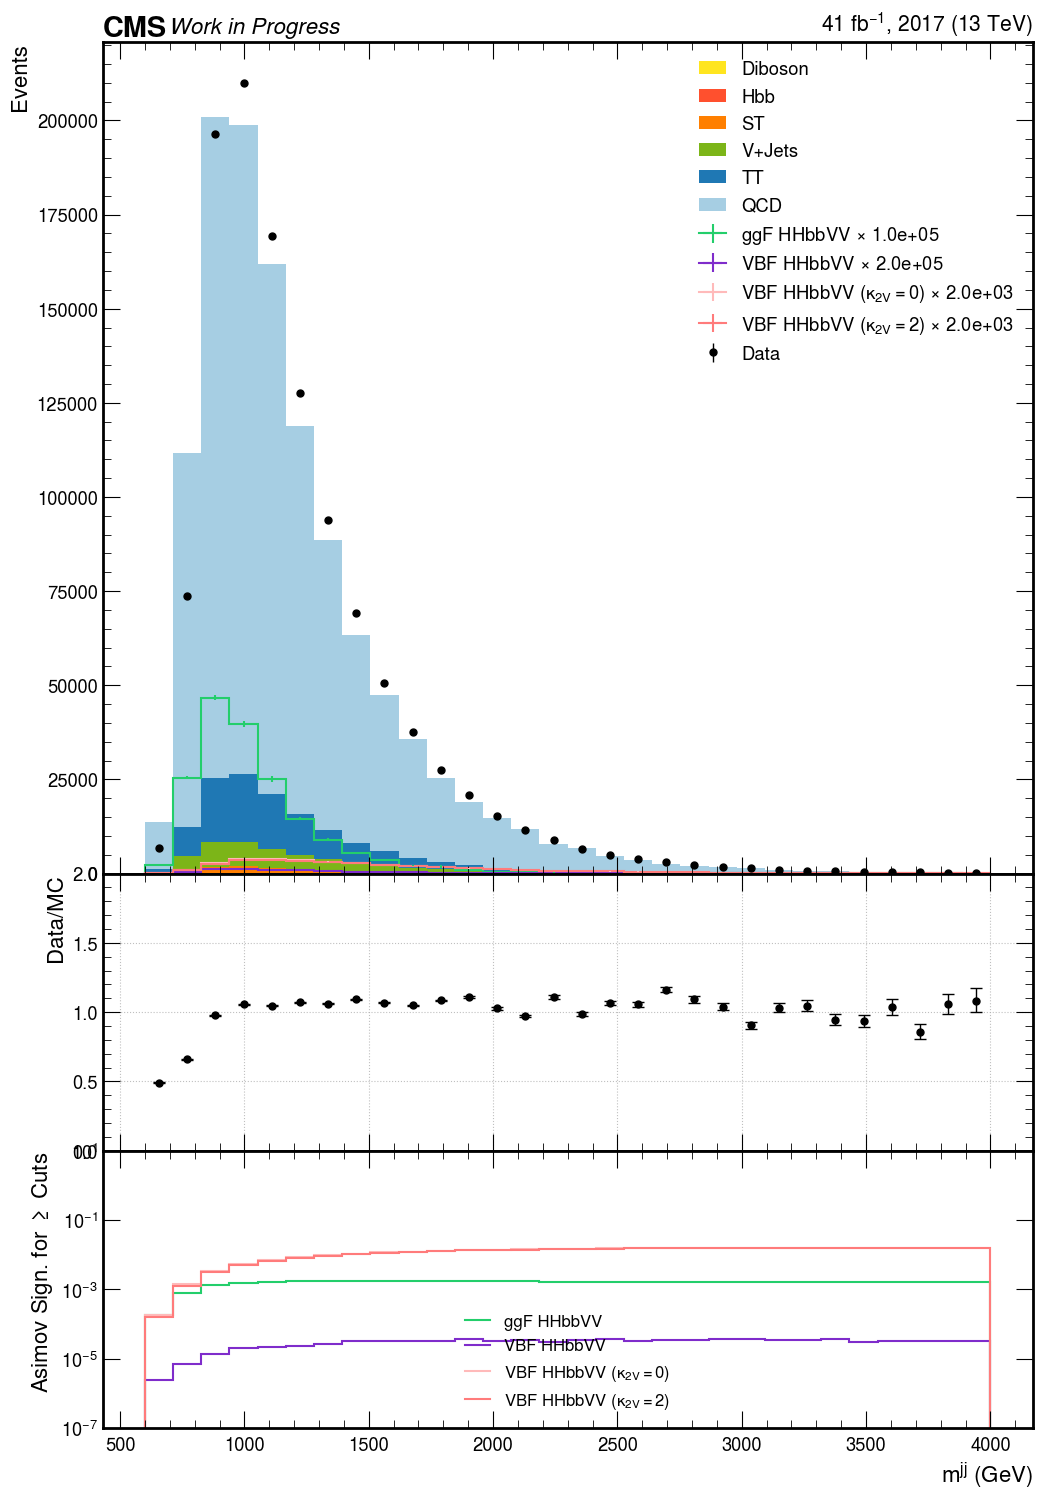

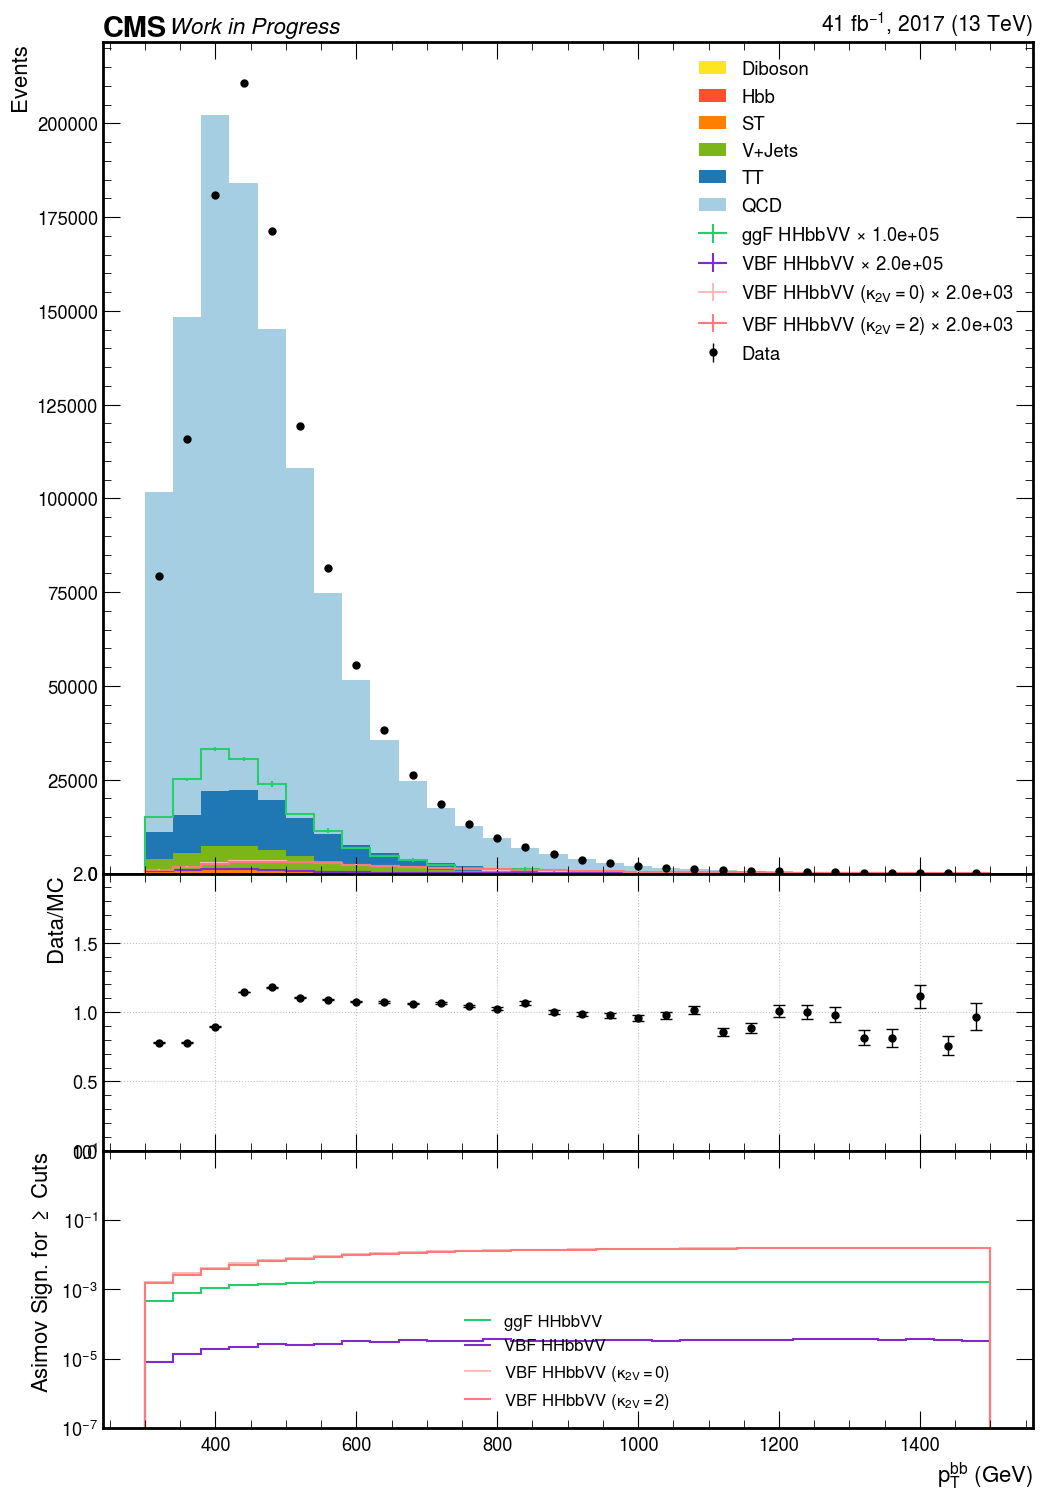

/home/users/annava/projects/HHbbVV/src/HHbbVV/postprocessing/plotting.py:197: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * ((s + b) * np.log(1 + (s / b)) - s))


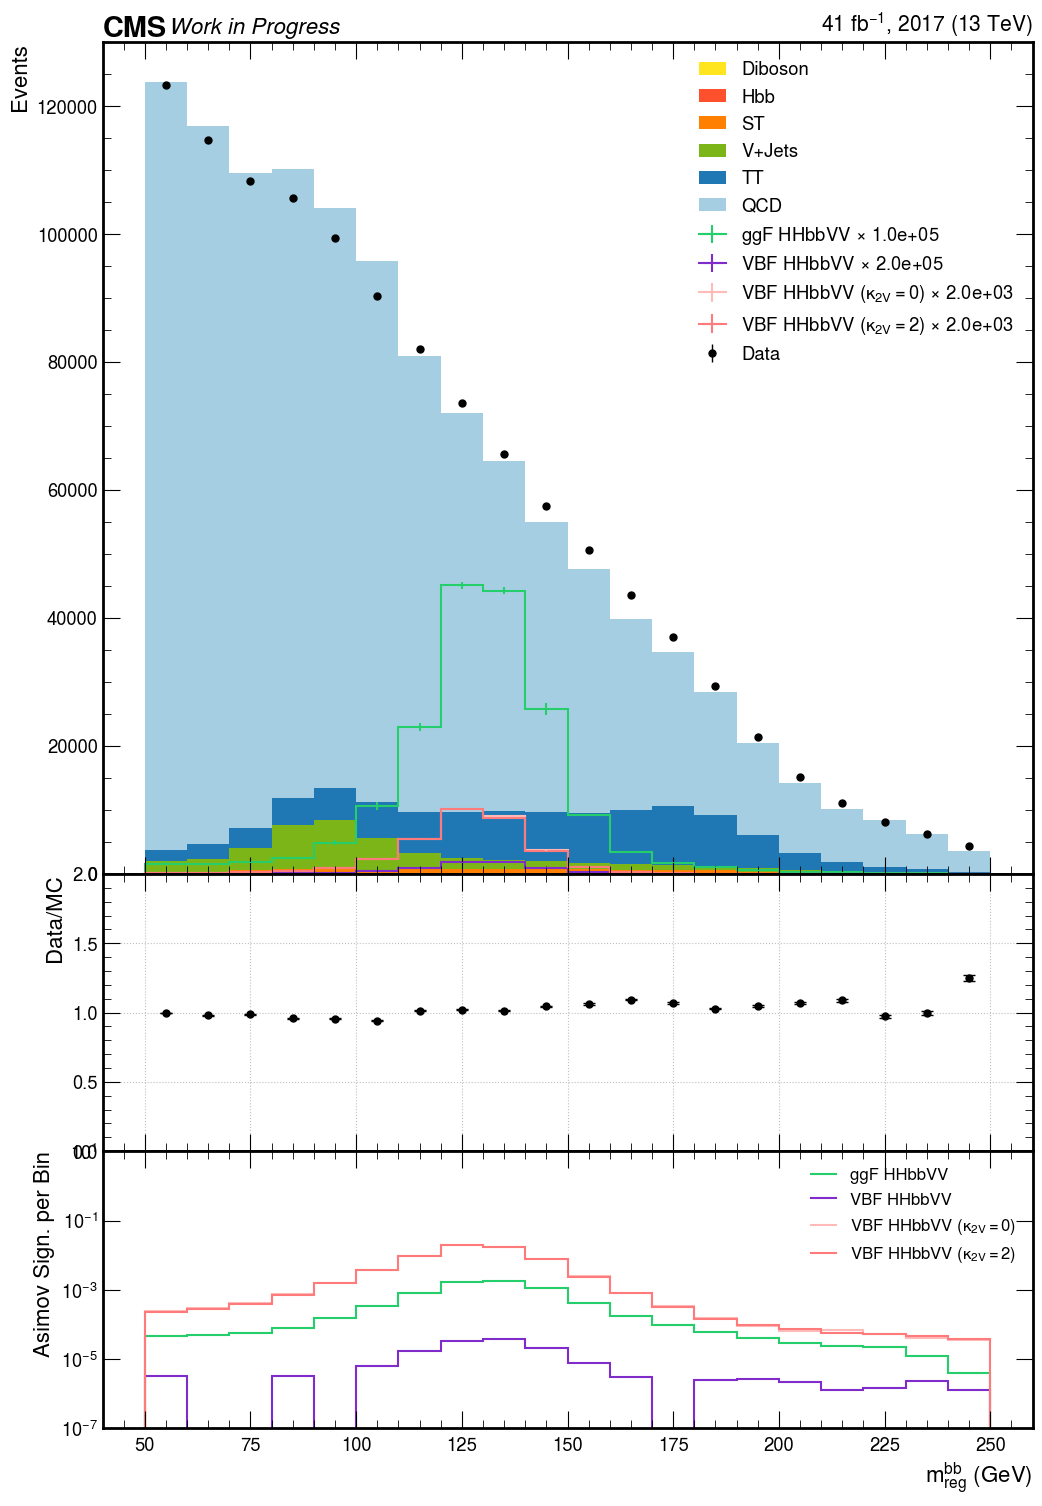

In [7]:
# {var: (bins, label)}
control_plot_vars = [
    # ShapeVar(var="MET_pt", label=r"$p^{miss}_T$ (GeV)", bins=[50, 0, 300]),
    # ShapeVar(var="DijetEta", label=r"$\eta^{jj}$", bins=[30, -8, 8]),
    # ShapeVar(var="DijetPt", label=r"$p_T^{jj}$ (GeV)", bins=[30, 0, 750]),
    ShapeVar(var="DijetMass", label=r"$m^{jj}$ (GeV)", bins=[30, 600, 4000]),
    # ShapeVar(var="bbFatJetEta", label=r"$\eta^{bb}$", bins=[30, -2.4, 2.4]),
    ShapeVar(var="bbFatJetPt", label=r"$p^{bb}_T$ (GeV)", bins=[30, 300, 1500], significance_dir="right"),
    ShapeVar(var="bbFatJetParticleNetMass", label=r"$m^{bb}_{reg}$ (GeV)", bins=[20, 50, 250], significance_dir="bin"),
    # ShapeVar(var="bbFatJetMsd", label=r"$m^{bb}_{msd}$ (GeV)", bins=[50, 0, 300]),
    # ShapeVar(var="bbFatJetParticleNetMD_Txbb", label=r"$T^{bb}_{Xbb}$", bins=[50, 0.8, 1]),
    # ShapeVar(var="VVFatJetEta", label=r"$\eta^{VV}$", bins=[30, -2.4, 2.4]),
    # ShapeVar(var="VVFatJetPt", label=r"$p^{VV}_T$ (GeV)", bins=[30, 300, 1500]),
    # ShapeVar(var="VVParticleNetMass", label=r"$m^{VV}_{reg}$ (GeV)", bins=[20, 50, 250]),
    # ShapeVar(var="VVFatJetMsd", label=r"$m^{VV}_{msd}$ (GeV)", bins=[40, 50, 250]),
    # ShapeVar(var="VVFatJetParticleNet_Th4q", label=r"Prob($H \to 4q$) vs Prob(QCD) (Non-MD)", bins=[50, 0, 1]),
    # ShapeVar(var="VVFatJetParTMD_THWW4q", label=r"Prob($H \to VV \to 4q$) vs Prob(QCD) (Mass-Decorrelated)", bins=[50, 0, 1]),
    # ShapeVar(var="VVFatJetParTMD_probT", label=r"Prob(Top) (Mass-Decorrelated)", bins=[50, 0, 1]),
    # ShapeVar(var="VVFatJetParTMD_THWWvsT", label=r"$T^{VV}_{HWW}$", bins=[50, 0, 1]),
    # ShapeVar(var="bbFatJetPtOverDijetPt", label=r"$p^{bb}_T / p_T^{jj}$", bins=[50, 0, 40]),
    # ShapeVar(var="VVFatJetPtOverDijetPt", label=r"$p^{VV}_T / p_T^{jj}$", bins=[50, 0, 40]),
    # ShapeVar(var="VVFatJetPtOverbbFatJetPt", label=r"$p^{VV}_T / p^{bb}_T$", bins=[50, 0.4, 2.0]),
    # ShapeVar(var="nGoodMuons", label=r"# of Muons", bins=[3, 0, 3]),
    # ShapeVar(var="nGoodElectrons", label=r"# of Electrons", bins=[3, 0, 3]),
    # ShapeVar(var="nGoodJets", label=r"# of AK4 B-Jets", bins=[5, 0, 5]),
    # ShapeVar(var="BDTScore", label=r"BDT Score", bins=[50, 0, 1]),
]

hists = postprocessing.control_plots(
    events_dict,
    bb_masks,
    ["HHbbVV", "VBFHHbbVV", "qqHH_CV_1_C2V_0_kl_1_HHbbVV", "qqHH_CV_1_C2V_2_kl_1_HHbbVV"],
    control_plot_vars,
    f"{plot_dir}/ControlPlots/{year}/",
    year,
    bg_keys=bg_keys,
    # bg_keys=["QCD", "TT", "ST", "V+Jets", "Hbb"],
    sig_scale_dict={
        "HHbbVV": 1e5,
        "VBFHHbbVV": 2e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e3,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e3,
    },
    plot_significance=True,
    show=True,
    log=False,
)

Templates

pass
                               Preselection   TriggerEffs        QCD SF  \
QCD                            2.193080e+06  1.152934e+06  1.003851e+06   
TT                             1.471054e+05  9.521809e+04  9.521809e+04   
ST                             1.336835e+04  8.895333e+03  8.895333e+03   
V+Jets                         6.317644e+04  3.844857e+04  3.844857e+04   
Diboson                        9.859687e+02  6.242251e+02  6.242251e+02   
ggFHbb                         3.946397e+02  2.378208e+02  2.378208e+02   
VBFHbb                         1.046515e+02  6.836515e+01  6.836515e+01   
ZHbb                           1.044506e+02  6.775973e+01  6.775973e+01   
WHbb                           1.593979e+02  1.035296e+02  1.035296e+02   
ggZHbb                         1.524993e+01  1.008643e+01  1.008643e+01   
ttHbb                          4.669228e+02  3.393894e+02  3.393894e+02   
Data                           1.147864e+06  1.147864e+06  1.147864e+06   
HHbbVV              

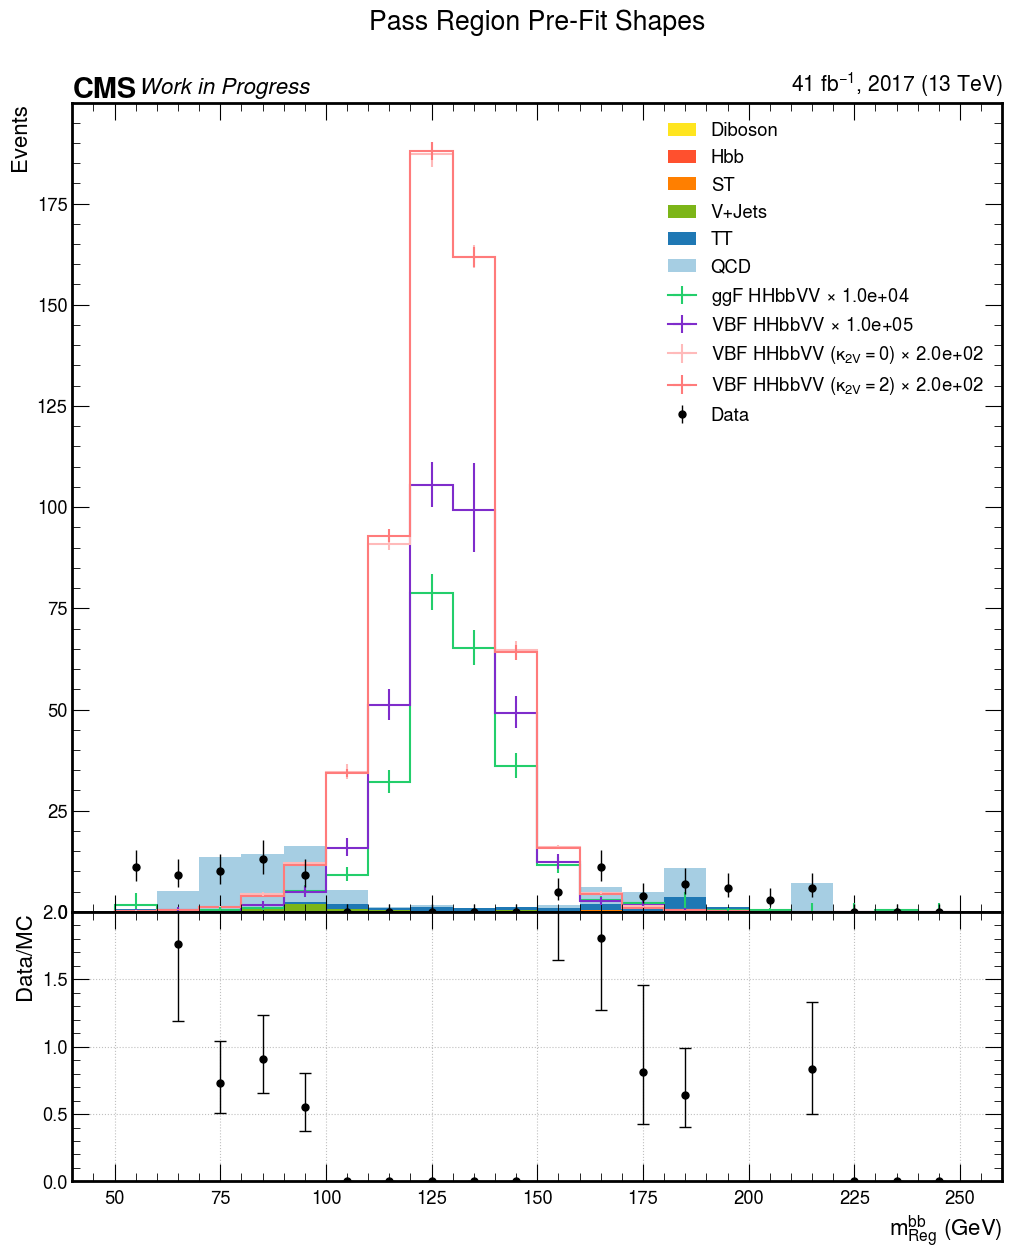

fail
                               Preselection   TriggerEffs        QCD SF  \
QCD                            2.193080e+06  1.152934e+06  1.003851e+06   
TT                             1.471054e+05  9.521809e+04  9.521809e+04   
ST                             1.336835e+04  8.895333e+03  8.895333e+03   
V+Jets                         6.317644e+04  3.844857e+04  3.844857e+04   
Diboson                        9.859687e+02  6.242251e+02  6.242251e+02   
ggFHbb                         3.946397e+02  2.378208e+02  2.378208e+02   
VBFHbb                         1.046515e+02  6.836515e+01  6.836515e+01   
ZHbb                           1.044506e+02  6.775973e+01  6.775973e+01   
WHbb                           1.593979e+02  1.035296e+02  1.035296e+02   
ggZHbb                         1.524993e+01  1.008643e+01  1.008643e+01   
ttHbb                          4.669228e+02  3.393894e+02  3.393894e+02   
Data                           1.147864e+06  1.147864e+06  1.147864e+06   
HHbbVV              

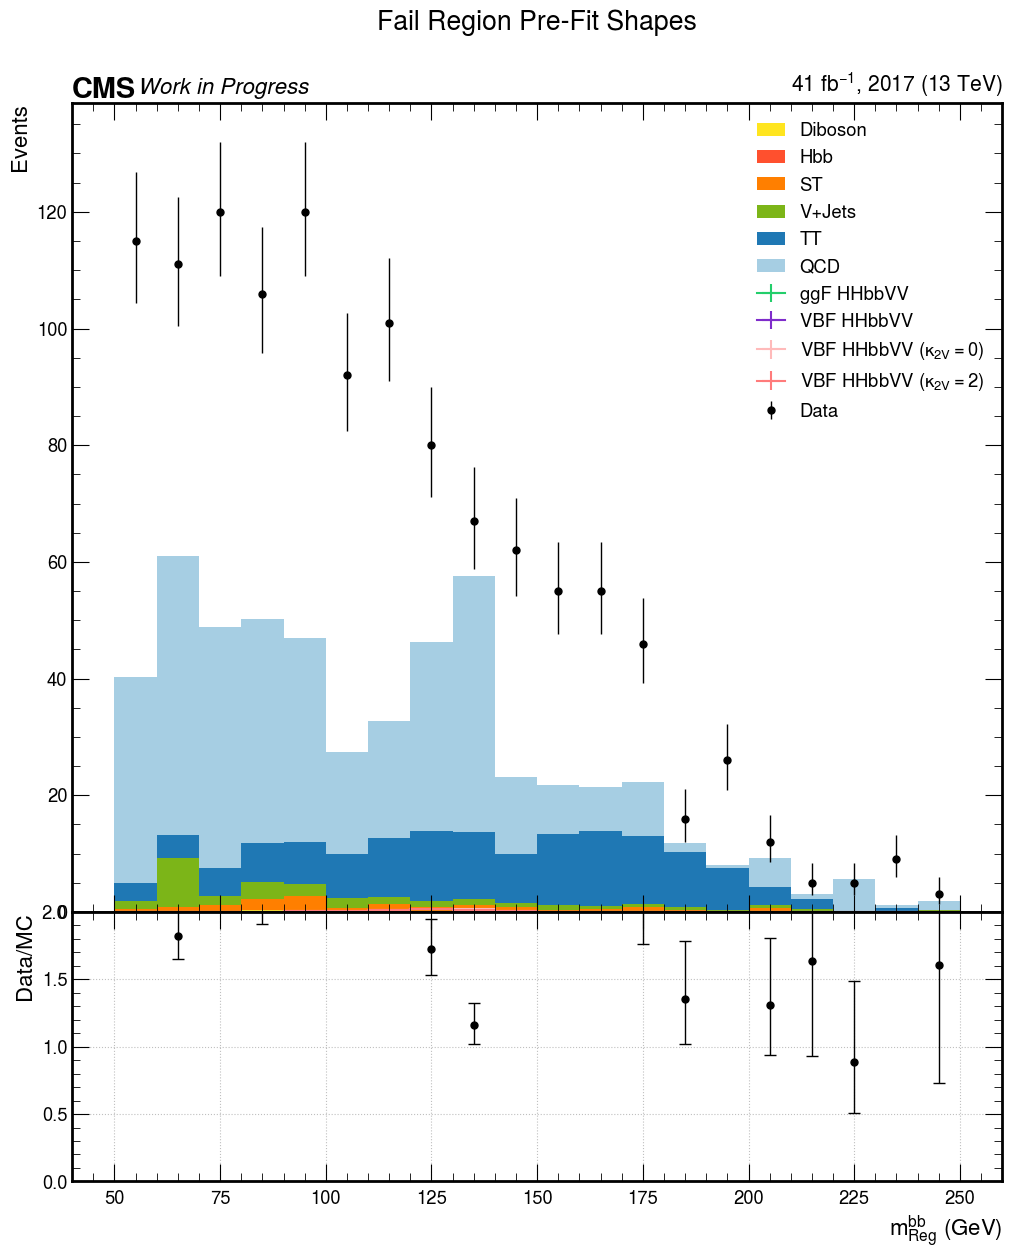

,Preselection,TriggerEffs,QCD SF
QCD,2.193080e+06,1.152934e+06,1.003851e+06
TT,1.471054e+05,9.521809e+04,9.521809e+04
ST,1.336835e+04,8.895333e+03,8.895333e+03
V+Jets,6.317644e+04,3.844857e+04,3.844857e+04
Diboson,9.859687e+02,6.242251e+02,6.242251e+02
ggFHbb,3.946397e+02,2.378208e+02,2.378208e+02
VBFHbb,1.046515e+02,6.836515e+01,6.836515e+01
ZHbb,1.044506e+02,6.775973e+01,6.775973e+01
WHbb,1.593979e+02,1.035296e+02,1.035296e+02
ggZHbb,1.524993e+01,1.008643e+01,1.008643e+01


In [8]:
# add actual cuts here
selection_regions = {
    "pass": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [0.985, CUT_MAX_VAL],
            ('nGoodVBFJets', 0): [2,40],
            ('vbf_Mass_jj', 0): [500,10000],
            ('vbf_dEta_jj', 0): [4,10000],
            'VVFatJetParticleNet_Th4q': [0.9,1]
            
        },
        label="Pass",
    ),
    "fail": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [-CUT_MAX_VAL, 0.985],
            ('nGoodVBFJets', 0): [2,40],
            ('vbf_Mass_jj', 0): [500,10000],
            ('vbf_dEta_jj', 0): [4,10000],
            'VVFatJetParticleNet_Th4q': [0.9,1]
        },
        label="Fail",
    ),
}

# variable to plot
shape_vars = [
    postprocessing.ShapeVar(
        "bbFatJetParticleNetMass",
        r"$m^{bb}_\mathrm{Reg}$ (GeV)",
        [20, 50, 250],
        reg=True,
        blind_window=[100, 150],
    ),
]



t = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    nonres_sig_keys,
    selection_regions,
    shape_vars,
    systematics,
    bg_keys=bg_keys,
    plot_sig_keys=[
        "HHbbVV",
        "VBFHHbbVV",
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    ],
    sig_scale_dict={
        "HHbbVV": 1e4,
        "VBFHHbbVV": 1e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e2,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e2,
    },
    plot_dir=f"{plot_dir}/templates",
    prev_cutflow=cutflow,
    weight_shifts={},
    jshift="",
    plot_shifts=False,
    lpsfs=False,
    show=True,
)
cutflow

Here we extracted the data used in datacard (get_templates() prints out the cutflow.)

pass
                               Preselection   TriggerEffs        QCD SF  \
QCD                            2.193080e+06  1.152934e+06  1.003851e+06   
TT                             1.471054e+05  9.521809e+04  9.521809e+04   
ST                             1.336835e+04  8.895333e+03  8.895333e+03   
V+Jets                         6.317644e+04  3.844857e+04  3.844857e+04   
Diboson                        9.859687e+02  6.242251e+02  6.242251e+02   
ggFHbb                         3.946397e+02  2.378208e+02  2.378208e+02   
VBFHbb                         1.046515e+02  6.836515e+01  6.836515e+01   
ZHbb                           1.044506e+02  6.775973e+01  6.775973e+01   
WHbb                           1.593979e+02  1.035296e+02  1.035296e+02   
ggZHbb                         1.524993e+01  1.008643e+01  1.008643e+01   
ttHbb                          4.669228e+02  3.393894e+02  3.393894e+02   
Data                           1.147864e+06  1.147864e+06  1.147864e+06   
HHbbVV              

/home/users/annava/mambaforge/envs/cofenv/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


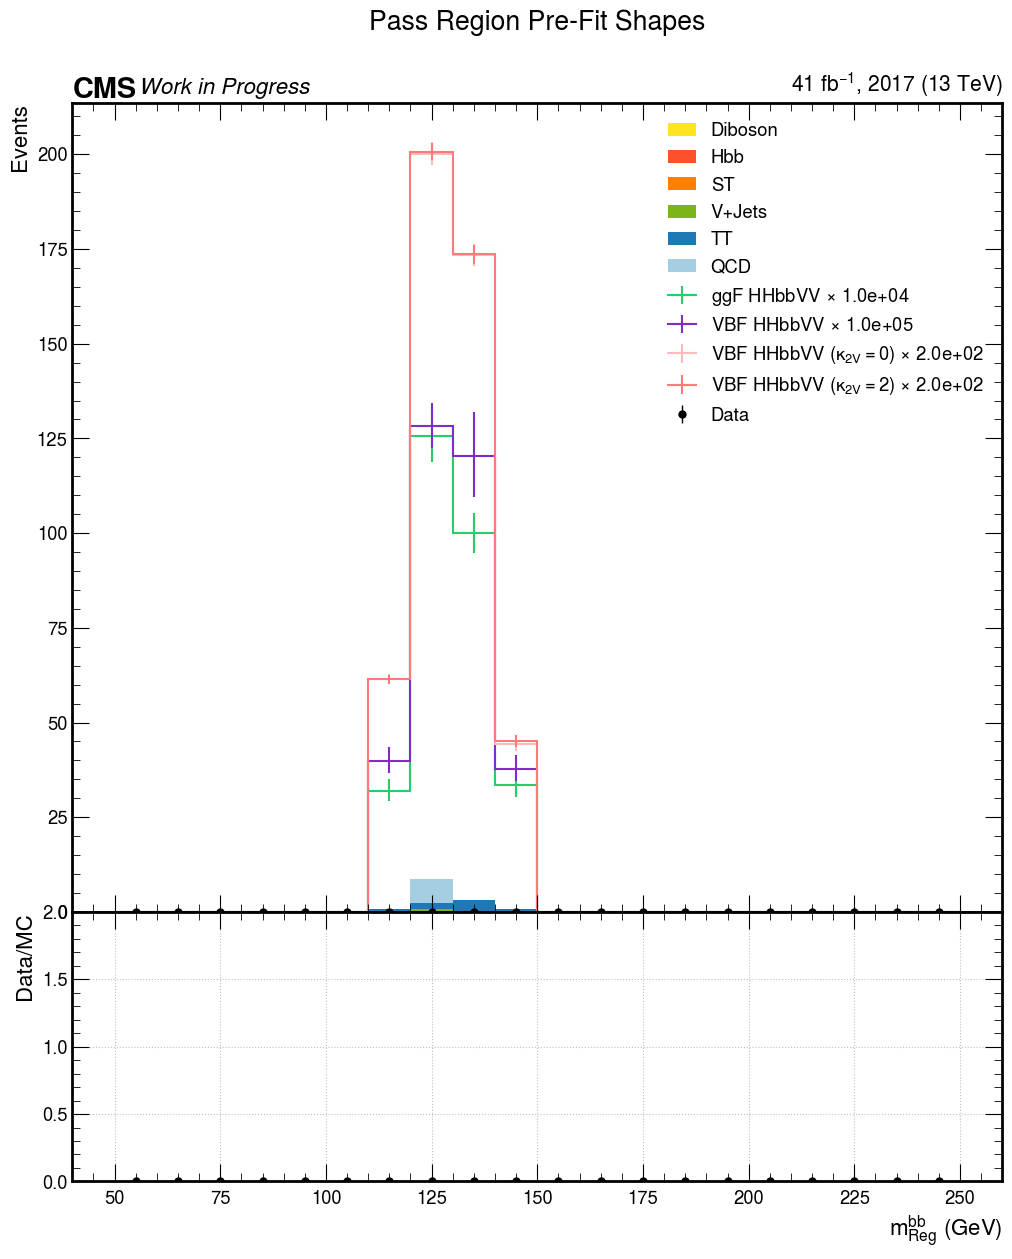

fail
                               Preselection   TriggerEffs        QCD SF  \
QCD                            2.193080e+06  1.152934e+06  1.003851e+06   
TT                             1.471054e+05  9.521809e+04  9.521809e+04   
ST                             1.336835e+04  8.895333e+03  8.895333e+03   
V+Jets                         6.317644e+04  3.844857e+04  3.844857e+04   
Diboson                        9.859687e+02  6.242251e+02  6.242251e+02   
ggFHbb                         3.946397e+02  2.378208e+02  2.378208e+02   
VBFHbb                         1.046515e+02  6.836515e+01  6.836515e+01   
ZHbb                           1.044506e+02  6.775973e+01  6.775973e+01   
WHbb                           1.593979e+02  1.035296e+02  1.035296e+02   
ggZHbb                         1.524993e+01  1.008643e+01  1.008643e+01   
ttHbb                          4.669228e+02  3.393894e+02  3.393894e+02   
Data                           1.147864e+06  1.147864e+06  1.147864e+06   
HHbbVV              

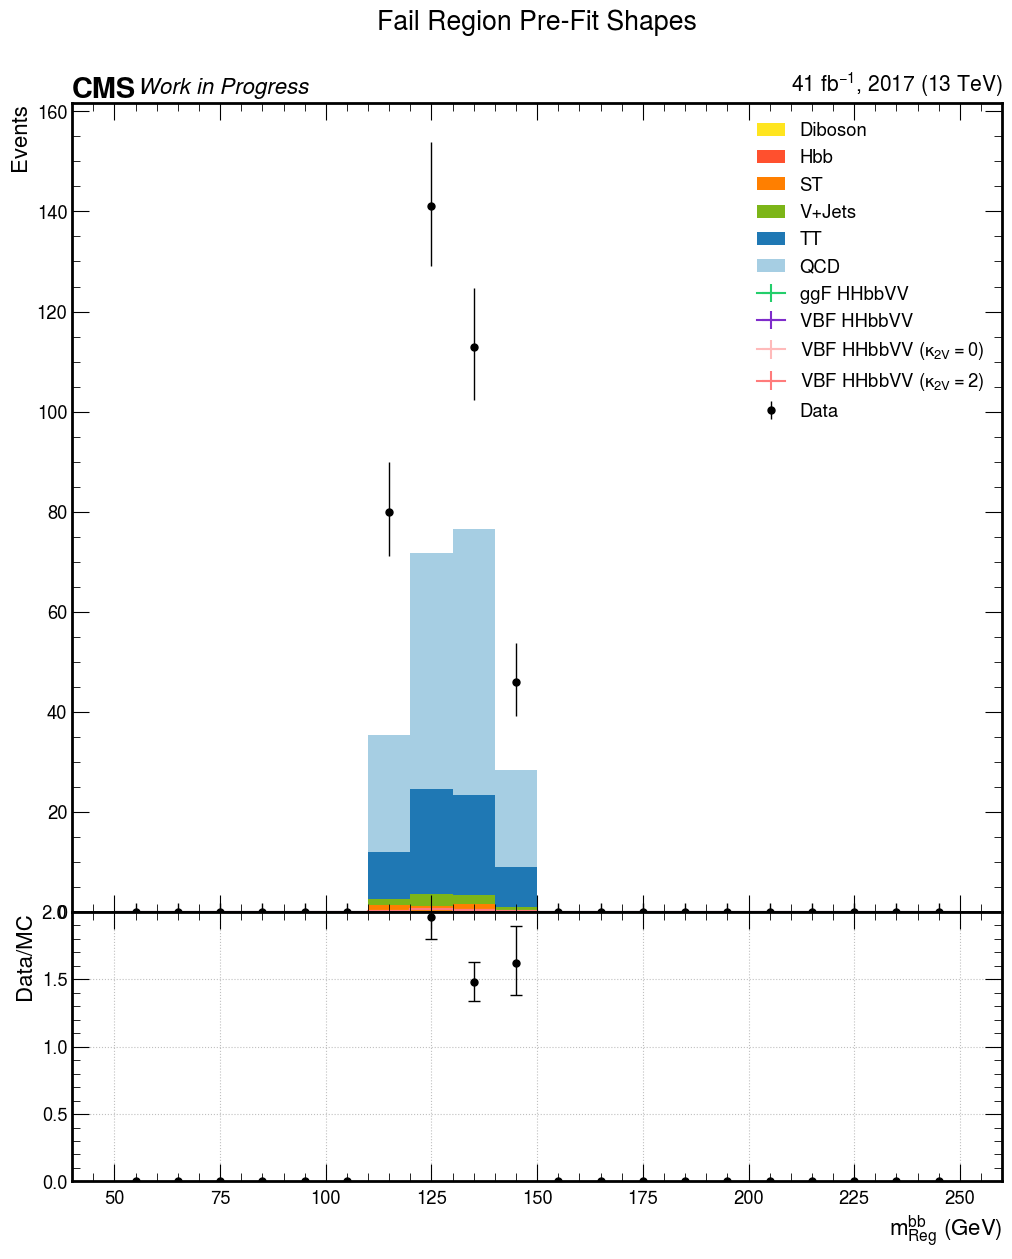

pass
Trigger SF Unc.: 0.014

fail
Trigger SF Unc.: 0.003

pass
Trigger SF Unc.: 0.008

fail
Trigger SF Unc.: 0.003



In [16]:
# variable to plot
shape_vars = [
    postprocessing.ShapeVar(
        "bbFatJetParticleNetMass",
        r"$m^{bb}_\mathrm{Reg}$ (GeV)",
        [20, 50, 250],
        reg=True,
        blind_window=[100, 150],
    ),
]
# A 


# first we will do 0 to 115 mass cut pass and fail region. then we do 145 to 100000 pass and fail. the sums give (C,D)
# then we do one of 115 to 145 pass and fail (A,B)and we record each of the homies.
selection_regions_control1 = {
    "pass": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [0.985, CUT_MAX_VAL],
            ('nGoodVBFJets', 0): [2,40],
            ('vbf_Mass_jj', 0): [400,10000],
            ('vbf_dEta_jj', 0): [3,10000],
            'VVFatJetParticleNet_Th4q': [0.9,1],
            "bbFatJetParticleNetMass": [145,100000],
        },
        label="Pass",
    ),
    "fail": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [-CUT_MAX_VAL, 0.985],
            ('nGoodVBFJets', 0): [2,40],
            ('vbf_Mass_jj', 0): [400,10000],
            ('vbf_dEta_jj', 0): [3,10000],
            'VVFatJetParticleNet_Th4q': [0.9,1],
            "bbFatJetParticleNetMass": [145,100000],
        },
        label="Fail",
    ),
}

selection_regions_control2 = {
    "pass": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [0.985, CUT_MAX_VAL],
            ('nGoodVBFJets', 0): [2,40],
            ('vbf_Mass_jj', 0): [400,10000],
            ('vbf_dEta_jj', 0): [3,10000],
            'VVFatJetParticleNet_Th4q': [0.9,1],
            "bbFatJetParticleNetMass": [0,115],
        },
        label="Pass",
    ),
    "fail": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [-CUT_MAX_VAL, 0.985],
            ('nGoodVBFJets', 0): [2,40],
            ('vbf_Mass_jj', 0): [400,10000],
            ('vbf_dEta_jj', 0): [3,10000],
            'VVFatJetParticleNet_Th4q': [0.9,1],
            "bbFatJetParticleNetMass": [0,115],
        },
        label="Fail",
    ),
}

selection_regions_signal = {
    "pass": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [0.985, CUT_MAX_VAL],
            ('nGoodVBFJets', 0): [2,40],
            ('vbf_Mass_jj', 0): [400,10000],
            ('vbf_dEta_jj', 0): [3,10000],
            'VVFatJetParticleNet_Th4q': [0.9,1],
            "bbFatJetParticleNetMass": [115,145],
        },
        label="Pass",
    ),
    "fail": postprocessing.Region(
        cuts={
            "bbFatJetParticleNetMD_Txbb": [-CUT_MAX_VAL, 0.985],
            ('nGoodVBFJets', 0): [2,40],
            ('vbf_Mass_jj', 0): [400,10000],
            ('vbf_dEta_jj', 0): [3,10000],
            'VVFatJetParticleNet_Th4q': [0.9,1],
            "bbFatJetParticleNetMass": [115,145],
        },
        label="Fail",
    ),
}


t_signal = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    nonres_sig_keys,
    selection_regions_signal,
    shape_vars,
    systematics,
    bg_keys=bg_keys,
    plot_sig_keys=[
        "HHbbVV",
        "VBFHHbbVV",
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    ],
    sig_scale_dict={
        "HHbbVV": 1e4,
        "VBFHHbbVV": 1e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e2,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e2,
    },
    plot_dir=f"{plot_dir}/templates",
    prev_cutflow=cutflow,
    weight_shifts={},
    jshift="",
    plot_shifts=False,
    lpsfs=False,
    show=True,
)

t_control1 = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    nonres_sig_keys,
    selection_regions_control1,
    shape_vars,
    systematics,
    bg_keys=bg_keys,
    plot_sig_keys=[
        "HHbbVV",
        "VBFHHbbVV",
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    ],
    sig_scale_dict={
        "HHbbVV": 1e4,
        "VBFHHbbVV": 1e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e2,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e2,
    },
    plot_dir=f"{plot_dir}/templates",
    prev_cutflow=cutflow,
    weight_shifts={},
    jshift="",
    plot_shifts=False,
    lpsfs=False,
    show=False,
)


t_control2 = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    nonres_sig_keys,
    selection_regions_control2,
    shape_vars,
    systematics,
    bg_keys=bg_keys,
    plot_sig_keys=[
        "HHbbVV",
        "VBFHHbbVV",
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV",
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV",
    ],
    sig_scale_dict={
        "HHbbVV": 1e4,
        "VBFHHbbVV": 1e5,
        "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 2e2,
        "qqHH_CV_1_C2V_2_kl_1_HHbbVV": 2e2,
    },
    plot_dir=f"{plot_dir}/templates",
    prev_cutflow=cutflow,
    weight_shifts={},
    jshift="",
    plot_shifts=False,
    lpsfs=False,
    show=False,
)




In [10]:
t

{'pass': Hist(
   StrCategory(['HHbbVV', 'ggHH_kl_2p45_kt_1_HHbbVV', 'ggHH_kl_5_kt_1_HHbbVV', 'ggHH_kl_0_kt_1_HHbbVV', 'VBFHHbbVV', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV', 'QCD', 'TT', 'ST', 'V+Jets', 'Diboson', 'ggFHbb', 'VBFHbb', 'ZHbb', 'WHbb', 'ggZHbb', 'ttHbb', 'Data', 'HHbbVV_txbb_down', 'ggHH_kl_2p45_kt_1_HHbbVV_txbb_down', 'ggHH_kl_5_kt_1_HHbbVV_txbb_down', 'ggHH_kl_0_kt_1_HHbbVV_txbb_down', 'VBFHHbbVV_txbb_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_down', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_down', 'HHbbVV_txbb_up', 'ggHH_kl_2p45_kt_1_HHbbVV_txbb_up', 'ggHH_kl_5_kt_1_HHbbVV_txbb_up', 'ggHH_kl_0_kt_1_HHbbVV_txbb_up', 'VBFHHbbVV_txbb_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb

In [18]:
categories =  ['HHbbVV', 'ggHH_kl_2p45_kt_1_HHbbVV', 'ggHH_kl_5_kt_1_HHbbVV', 'ggHH_kl_0_kt_1_HHbbVV', 'VBFHHbbVV', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV', 
               'qqHH_CV_1_C2V_1_kl_2_HHbbVV', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV', 'QCD', 'TT', 'ST', 'V+Jets', 'Diboson', 
               'ggFHbb', 'VBFHbb', 'ZHbb', 'WHbb', 'ggZHbb', 'ttHbb', 'Data', 'HHbbVV_txbb_down', 'ggHH_kl_2p45_kt_1_HHbbVV_txbb_down', 'ggHH_kl_5_kt_1_HHbbVV_txbb_down', 'ggHH_kl_0_kt_1_HHbbVV_txbb_down', 
               'VBFHHbbVV_txbb_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_down', 
               'qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_down', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_down', 'HHbbVV_txbb_up', 'ggHH_kl_2p45_kt_1_HHbbVV_txbb_up', 'ggHH_kl_5_kt_1_HHbbVV_txbb_up', 'ggHH_kl_0_kt_1_HHbbVV_txbb_up', 
               'VBFHHbbVV_txbb_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_up', 
               'qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_up', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_up']
hhbbvv_index = categories.index('HHbbVV')
index = categories.index('Data')



# Assuming you have the Hist objects as hist_pass and hist_fail
hist_pass = t_signal['pass']
hist_fail = t_signal['fail']

hist_pass_values = hist_pass.values()
hist_fail_values = hist_fail.values()


hhbbvv_values_pass = hist_pass_values[index]
hhbbvv_values_fail = hist_fail_values[index]


print(type(hist_pass.values()))
#print(hist_pass.values())
print(dir(hist_pass))

total_events_pass = np.sum(hhbbvv_values_pass)
total_events_fail = np.sum(hhbbvv_values_fail)

print(f"Total number of 'HHbbVV' events in 'pass' histogram: {total_events_pass}") # 0.023298 
print(f"Total number of 'HHbbVV' events in 'fail' histogram: {total_events_fail}") # 0.019126




<class 'numpy.ndarray'>
['__add__', '__annotations__', '__array__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__idiv__', '__imul__', '__init__', '__init_subclass__', '__isub__', '__itruediv__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '_axis', '_clone', '_compute_commonindex', '_compute_inplace_op', '_compute_uhi_index', '_export_bh_', '_family', '_from_histogram_cpp', '_from_histogram_object', '_generate_axes_', '_hist', '_import_bh_', '_index_transform', '_loc_shortcut', '_name_to_index', '_new_hist', '_reduce', '_repr_html_', '_step_shortcut', '_storage_type', '_types', '_va

In [21]:

datasets_of_interest = ['VBFHHbbVV', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV', 'Data']
abcd_regions = {}
categories =  ['HHbbVV', 'ggHH_kl_2p45_kt_1_HHbbVV', 'ggHH_kl_5_kt_1_HHbbVV', 'ggHH_kl_0_kt_1_HHbbVV', 'VBFHHbbVV', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV', 
               'qqHH_CV_1_C2V_1_kl_2_HHbbVV', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV', 'qqHH_CV_1_C2V_1_kl_0_HHbbVV', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV', 'QCD', 'TT', 'ST', 'V+Jets', 'Diboson', 
               'ggFHbb', 'VBFHbb', 'ZHbb', 'WHbb', 'ggZHbb', 'ttHbb', 'Data', 'HHbbVV_txbb_down', 'ggHH_kl_2p45_kt_1_HHbbVV_txbb_down', 'ggHH_kl_5_kt_1_HHbbVV_txbb_down', 'ggHH_kl_0_kt_1_HHbbVV_txbb_down', 
               'VBFHHbbVV_txbb_down', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_down', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_down', 
               'qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_down', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_down', 'HHbbVV_txbb_up', 'ggHH_kl_2p45_kt_1_HHbbVV_txbb_up', 'ggHH_kl_5_kt_1_HHbbVV_txbb_up', 'ggHH_kl_0_kt_1_HHbbVV_txbb_up', 
               'VBFHHbbVV_txbb_up', 'qqHH_CV_1_C2V_0_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1p5_C2V_1_kl_1_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_1_kl_2_HHbbVV_txbb_up', 'qqHH_CV_1_C2V_2_kl_1_HHbbVV_txbb_up', 
               'qqHH_CV_1_C2V_1_kl_0_HHbbVV_txbb_up', 'qqHH_CV_0p5_C2V_1_kl_1_HHbbVV_txbb_up']


# Loop through each dataset of interest
for dataset in datasets_of_interest:
    # Find the index in the categories list
    dataset_index = categories.index(dataset)
    
    # Initialize a sub-dictionary to hold the results for this dataset
    abcd_regions[dataset] = {}
    
    # Loop through 'pass' and 'fail'
    for pass_fail in ['pass', 'fail']:
        # Extract the number of events from each template (two for control since it is disjointed)
        hist_values_signal = t_signal[pass_fail].values()
        total_events_signal = np.sum(hist_values_signal[dataset_index])
        
        hist_values_control1 = t_control1[pass_fail].values()
        total_events_control1 = np.sum(hist_values_control1[dataset_index])
        
        hist_values_control2 = t_control2[pass_fail].values()
        total_events_control2 = np.sum(hist_values_control2[dataset_index])
        
        total_events_control = total_events_control1 + total_events_control2
        
        abcd_regions[dataset][f"signal_{pass_fail}"] = total_events_signal
        abcd_regions[dataset][f"control_{pass_fail}"] = total_events_control


abcd_regions


{'VBFHHbbVV': {'signal_pass': 0.0032627285561860836,
  'control_pass': 0.0009252579917810686,
  'signal_fail': 0.002112246296786831,
  'control_fail': 0.001162795976265986},
 'qqHH_CV_1_C2V_2_kl_1_HHbbVV': {'signal_pass': 2.4037462032938857,
  'control_pass': 0.6996798709103303,
  'signal_fail': 1.2437486811731266,
  'control_fail': 0.6474755352182396},
 'qqHH_CV_1_C2V_0_kl_1_HHbbVV': {'signal_pass': 2.3961491660031724,
  'control_pass': 0.7090858266540406,
  'signal_fail': 1.2981817887350626,
  'control_fail': 0.6921296153236296},
 'Data': {'signal_pass': 0.0,
  'control_pass': 154.0,
  'signal_fail': 380.0,
  'control_fail': 1785.0}}

In [22]:
def generate_datacard(data_values, signal_values):
    """Generate a datacard string based on the given values."""
    return f"""imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin 	 chA 	 chB 	 chC 	 chD
observation 	   {data_values['signal_pass']} 	  {data_values['signal_fail']} 	 {data_values['control_pass']} 	 {data_values['control_fail']}
------------------------------
bin 	 chA 	 chA 	 chB 	 chB 	 chC 	 chC 	 chD 	 chD
process 	 sig	 bkg 	 sig	 bkg 	 sig	 bkg 	 sig	 bkg
process 	 0	 1	 0	 1	 0	 1	 0	 1
rate	 {signal_values['signal_pass']} 	 1 	 {signal_values['signal_fail']} 	 1 	 {signal_values['control_pass']} 	 1 	 {signal_values['control_fail']} 	 1
------------------------------
single_A    rateParam       chA     bkg      (@0*@1/@2)                    single_B,single_C,single_D
single_B    rateParam       chB     bkg     {data_values['signal_fail']}
single_C    rateParam       chC     bkg     {data_values['control_pass']}
single_D    rateParam       chD     bkg     {data_values['control_fail']}
norm rateParam * sig 1
single_lumi 	 lnN 	 1.2	 -  	 1.2	 -  	 1.2	 -  	 1.2	 -  
"""

# Extract Data values
data_values = abcd_regions['Data']

# Loop through each signal and generate a datacard
for dataset in datasets_of_interest:
    if dataset == 'Data':  # Skip 'Data'
        continue
    signal_values = abcd_regions[dataset]
    datacard_text = generate_datacard(data_values, signal_values)
    
    # Save to a text file
    filename = f"/home/users/annava/CMSSW_12_3_4/src/HiggsAnalysis/CombinedLimit/datacards/datacard_{dataset}.txt"
    with open(filename, "w") as f:
        f.write(datacard_text)
        
    print(f"Datacard for {dataset} has been saved as {filename}.")


{'VBFHHbbVV': {'signal_pass': 0.0032627285561860836, 'control_pass': 0.0009252579917810686, 'signal_fail': 0.002112246296786831, 'control_fail': 0.001162795976265986}, 'qqHH_CV_1_C2V_2_kl_1_HHbbVV': {'signal_pass': 2.4037462032938857, 'control_pass': 0.6996798709103303, 'signal_fail': 1.2437486811731266, 'control_fail': 0.6474755352182396}, 'qqHH_CV_1_C2V_0_kl_1_HHbbVV': {'signal_pass': 2.3961491660031724, 'control_pass': 0.7090858266540406, 'signal_fail': 1.2981817887350626, 'control_fail': 0.6921296153236296}, 'Data': {'signal_pass': 0.0, 'control_pass': 154.0, 'signal_fail': 380.0, 'control_fail': 1785.0}}
Datacard for VBFHHbbVV has been saved as /home/users/annava/projects/HHbbVV/src/HHbbVV/VBF_binder/vbf_tests_output/datacard_VBFHHbbVV.txt.
Datacard for qqHH_CV_1_C2V_2_kl_1_HHbbVV has been saved as /home/users/annava/projects/HHbbVV/src/HHbbVV/VBF_binder/vbf_tests_output/datacard_qqHH_CV_1_C2V_2_kl_1_HHbbVV.txt.
Datacard for qqHH_CV_1_C2V_0_kl_1_HHbbVV has been saved as /home/user

In [12]:


C = (0.380591+0.705142 )/(1752.5063309999998 + 3264.734414)  #(0.440593 + 0.222956) / (122.0 + 68.0)
# fail control D

D1 = (0.295384+0.817020)/(3690.896753 + 2894.3845) # (0.484652 + 0.162842)/(1285.0 + 502.0)
print(C,D1)


0.000216400419111242 0.00016892277751891487


In [13]:
0.440593 + 0.222956, (122.0 + 68.0)
(0.484652 + 0.162842),(1285.0 + 502.0)

(0.647494, 1787.0)